# Calibration

## 1 Aggregation

### 1.1 Cameras

In [49]:
import os
import pandas as pd

def aggregate_cameras_day(folder_path, specific_date):
    # Initialize an empty DataFrame to store aggregated results
    aggregated_results = pd.DataFrame()

    # Construct the filename for the specific date
    filename = f"detect_results_{specific_date}.csv"
    
    # Check if the file exists in the folder
    file_path = os.path.join(folder_path, filename)
    if os.path.exists(file_path):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Convert the timestamp column to datetime format
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Extract the hour from the timestamp
        df['hour'] = df['timestamp'].dt.hour
        
        # Group by camera_id and hour, and calculate the sum of each vehicle category
        hourly_sum = df.drop(columns=['timestamp']).groupby(['camera_id', 'hour']).sum().reset_index()
        
        # Calculate the total count of all vehicle categories for each group
        hourly_sum['total'] = hourly_sum.iloc[:, 2:].sum(axis=1)
        
        # Calculate the proportion of each vehicle category for each group
        for col in hourly_sum.columns[2:-1]:
            hourly_sum[f'{col}_cam'] = hourly_sum[col] / hourly_sum['total']
        
        # Add a column for the date
        hourly_sum['date'] = specific_date
        
        # Append the results to the aggregated DataFrame
        aggregated_results = pd.concat([aggregated_results, hourly_sum], ignore_index=True)
    
    return aggregated_results


In [50]:
def aggregate_cameras_days(folder_path, start_date, end_date):
    # Initialize an empty DataFrame to store aggregated results for the date range
    all_results = pd.DataFrame()

    # Generate a list of dates within the specified range
    date_range = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m-%d')

    # Iterate over each date in the date range
    for date in date_range:
        # Call the original function for each date
        daily_results = aggregate_cameras_day(folder_path, date)
        
        # Append the daily results to the all_results DataFrame
        all_results = pd.concat([all_results, daily_results], ignore_index=True)
    
    return all_results

In [51]:
folder_path = r"Z:\Data\HK\snapshot HK\detection\100s"
start_date = "2024-07-18"
end_date = "2024-08-10"
cameras = aggregate_cameras_days(folder_path, start_date, end_date)
cameras

,camera_id,hour,PC,HGV,HDB,TX,FBDD,LGV,LDB,MC,total,PC_cam,HGV_cam,HDB_cam,TX_cam,FBDD_cam,LGV_cam,LDB_cam,MC_cam,date
0,AID01101,16,8,5,0,5,0,1,5,3,27,0.296296,0.185185,0.000000,0.185185,0.000000,0.037037,0.185185,0.111111,2024-07-18
1,AID01101,17,20,1,1,4,1,3,7,1,38,0.526316,0.026316,0.026316,0.105263,0.026316,0.078947,0.184211,0.026316,2024-07-18
2,AID01101,18,19,1,0,6,1,0,1,2,30,0.633333,0.033333,0.000000,0.200000,0.033333,0.000000,0.033333,0.066667,2024-07-18
3,AID01101,19,21,0,0,6,1,1,3,1,33,0.636364,0.000000,0.000000,0.181818,0.030303,0.030303,0.090909,0.030303,2024-07-18
4,AID01101,20,16,0,1,6,2,0,5,1,31,0.516129,0.000000,0.032258,0.193548,0.064516,0.000000,0.161290,0.032258,2024-07-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361032,YL111F,19,158,10,1,57,30,6,22,1,285,0.554386,0.035088,0.003509,0.200000,0.105263,0.021053,0.077193,0.003509,2024-08-08
361033,YL111F,20,111,10,6,38,24,3,15,5,212,0.523585,0.047170,0.028302,0.179245,0.113208,0.014151,0.070755,0.023585,2024-08-08
361034,YL111F,21,95,8,5,41,12,4,10,2,177,0.536723,0.045198,0.028249,0.231638,0.067797,0.022599,0.056497,0.011299,2024-08-08
361035,YL111F,22,92,9,7,36,16,4,12,3,179,0.513966,0.050279,0.039106,0.201117,0.089385,0.022346,0.067039,0.016760,2024-08-08


### 1.2 Detectors

In [52]:
import os
import pandas as pd
from datetime import datetime

def aggregate_detectors(folder_path, start_date, end_date):
    # Convert start_date and end_date to datetime objects
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Initialize an empty DataFrame to store the aggregated data
    aggregated_data = pd.DataFrame()
    
    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a CSV file and matches the naming pattern
        if filename.endswith(".csv") and filename.startswith("prop_"):
            # Extract the date from the filename
            file_date_str = filename[5:-4]
            file_date = datetime.strptime(file_date_str, "%Y-%m-%d")
            
            # Check if the file date is within the specified date range
            if start_date <= file_date <= end_date:
                # Read the CSV file into a DataFrame
                file_path = os.path.join(folder_path, filename)
                df = pd.read_csv(file_path)
                
                # Filter rows where the 'valid' column is 'Y'
                df = df[df['valid'] == 'Y']
                
                # Convert period_from to datetime and extract the hour
                df['hour'] = pd.to_datetime(df['period_from'], format='%H:%M:%S').dt.hour
                
                # Add a date column
                df['date'] = file_date_str

                # Aggregate vehicle classes
                df['PC_det'] = df['PRIVATE CAR'] / 100
                df['HGV_det'] = df['MEDIUM/HEAVY GOODS VEHICLE'] / 100
                df['HDB_det'] = (df['NON-FRANCHISED BUS'] + df['FRANCHAISED BUS (S.D.)']) / 100
                df['TX_det'] = df['TAXI'] / 100
                df['FBDD_det'] = df['FRANCHIASED BUS (D.D.)'] / 100
                df['LGV_det'] = df['LIGHT GOODS VEHICLE'] / 100
                df['LDB_det'] = (df['PRIVATE LIGHT BUS'] + df['PUBLIC LIGHT BUS']) / 100
                df['MC_det'] = df['MOTOR CYCLE'] / 100
                
                # Select the required columns and append to the aggregated_data DataFrame
                selected_columns = ['detector_id', 'date', 'hour'] + ['PC_det', 'HGV_det', 'HDB_det', 'TX_det', 'FBDD_det', 'LGV_det', 'LDB_det', 'MC_det']
                aggregated_data = pd.concat([aggregated_data, df[selected_columns]], ignore_index=True)
    
    return aggregated_data

In [53]:
folder_path = r"Z:\Data\HK\vehprop HK\data"
start_date = "2024-07-18"
end_date = "2024-08-10"
detectors = aggregate_detectors(folder_path, start_date, end_date)
detectors

,detector_id,date,hour,PC_det,HGV_det,HDB_det,TX_det,FBDD_det,LGV_det,LDB_det,MC_det
0,ALPR90002,2024-07-18,0,0.504,0.017,0.006,0.370,0.000,0.092,0.011,0.000
1,CPR10001,2024-07-18,0,0.455,0.000,0.000,0.364,0.000,0.000,0.182,0.000
2,CPR20001,2024-07-18,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,CPRLT10001,2024-07-18,0,0.420,0.034,0.012,0.432,0.028,0.056,0.012,0.006
4,CPRLT20001,2024-07-18,0,0.411,0.010,0.010,0.416,0.015,0.096,0.020,0.020
...,...,...,...,...,...,...,...,...,...,...,...
36633,TPR10001,2024-08-10,0,0.697,0.035,0.008,0.089,0.034,0.102,0.033,0.002
36634,TPR20001,2024-08-10,0,0.653,0.049,0.009,0.100,0.037,0.091,0.052,0.009
36635,TPSH10001,2024-08-10,0,0.525,0.022,0.005,0.283,0.010,0.128,0.002,0.027
36636,TPSH20001,2024-08-10,0,0.608,0.024,0.004,0.181,0.011,0.156,0.002,0.015


## 2 Calibration

In [54]:
matched = pd.read_csv("../loading/matched/matched_cam_det.csv")
matched = matched[matched['Valid'] == True].reset_index(drop=True)
matched

,Device_ID,key,Valid,District,Road_EN,Direction,description
0,ALPR90002,TDS91064,True,Yeun Long,San Tin Highway,South,San Tin Highway near Geranium Path - Southboun...
1,ALPR90005,TDS90025,True,Tsuen Wan,Tuen Mun Road,North West,Tuen Mun Road near Sham Tseng - Westbound (1) ...
2,ALPR90005-2,TDS90025,True,Tsuen Wan,Tuen Mun Road,North West,Tuen Mun Road near Sham Tseng - Westbound (1) ...
3,CPRLT10001,TDSCPRLT10001,True,Yeun Long,Castle Peak Rd-Lam Tei,North East,Castle Peak Rd-Lam Tei near Lam Tei Interchang...
4,CPRLT20001,TDSCPRLT20001,True,Yeun Long,Castle Peak Rd-Lam Tei,South West,Castle Peak Rd-Lam Tei near Lam Tei Main Stree...
5,CWBR10001,TDSNCWBR20004,True,Sai Kung,Clear Water Bay Road,North West,New Clear Water Bay Road near On Sau Road - We...
6,JCR10001,TDSJCR10002,True,North,Jockey Club Road,South East,Jockey Club Road near Fanling Highway - Southb...
7,PFLR20001,H130F,True,Central and Western,Pok Fu Lam Road,South,Pok Fu Lam Road near Pokfield Road [H130F]
8,TCS01101-2,AID01108,True,Wan Chai,Wong Nai Chung Gap Flyover,North West,Wong Nai Chung Gap Flyover near Racecourse - N...
9,TCS01102,AID01114,True,Kowloon City,Princess Margaret Road,North West,Princess Margaret Road near Oi Man Estate - No...


In [55]:
matched_results = pd.DataFrame()
for id, pair in matched.iterrows():
    camera_id = pair['key']
    detector_id = pair['Device_ID']
    # merge camera and detector
    camera = cameras[cameras['camera_id'] == camera_id][['date', 'hour', 'PC_cam', 'HGV_cam', 'HDB_cam', 'TX_cam', 'FBDD_cam', 'LGV_cam', 'LDB_cam', 'MC_cam']]
    detector = detectors[detectors['detector_id'] == detector_id][['detector_id', 'date', 'hour', 'PC_det', 'HGV_det', 'HDB_det', 'TX_det', 'FBDD_det', 'LGV_det', 'LDB_det', 'MC_det']]
    matched_cam_det = pd.merge(detector, camera, on=['date', 'hour'])
    # transfer datetime
    matched_cam_det['date'] = pd.to_datetime(matched_cam_det['date'])
    # matched_cam_det['datetime'] = matched_cam_det.apply(lambda row: row['date'] + pd.Timedelta(hours=row['hour']), axis=1)
    # matched_cam_det.drop(columns=['date', 'hour'], inplace=True)
    matched_results = pd.concat([matched_results, matched_cam_det], ignore_index=True)

matched_results.dropna(inplace=True)
matched_results = matched_results.loc[~(matched_results[['PC_det', 'HGV_det', 'HDB_det', 'TX_det', 'FBDD_det', 'LGV_det', 'LDB_det', 'MC_det']] == 0).all(axis=1)]
matched_results

,detector_id,date,hour,PC_det,HGV_det,HDB_det,TX_det,FBDD_det,LGV_det,LDB_det,MC_det,PC_cam,HGV_cam,HDB_cam,TX_cam,FBDD_cam,LGV_cam,LDB_cam,MC_cam
0,ALPR90002,2024-07-18,16,0.562,0.055,0.013,0.103,0.003,0.235,0.028,0.001,0.338983,0.322034,0.016949,0.101695,0.016949,0.152542,0.050847,0.000000
1,ALPR90002,2024-07-18,17,0.632,0.032,0.010,0.093,0.004,0.207,0.022,0.000,0.370370,0.382716,0.000000,0.049383,0.049383,0.074074,0.049383,0.024691
2,ALPR90002,2024-07-18,18,0.711,0.019,0.015,0.081,0.001,0.155,0.018,0.001,0.539326,0.213483,0.000000,0.078652,0.044944,0.078652,0.033708,0.011236
3,ALPR90002,2024-07-18,19,0.673,0.012,0.013,0.135,0.001,0.152,0.014,0.001,0.425000,0.300000,0.000000,0.050000,0.050000,0.075000,0.100000,0.000000
4,ALPR90002,2024-07-18,20,0.688,0.017,0.011,0.141,0.000,0.130,0.014,0.000,0.414634,0.170732,0.097561,0.170732,0.048780,0.048780,0.048780,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9520,TKR10001,2024-08-08,13,0.638,0.059,0.016,0.119,0.000,0.135,0.021,0.011,0.538462,0.153846,0.000000,0.153846,0.000000,0.153846,0.000000,0.000000
9521,TKR10001,2024-08-08,14,0.779,0.058,0.000,0.058,0.000,0.096,0.000,0.010,0.428571,0.095238,0.000000,0.142857,0.000000,0.142857,0.190476,0.000000
9522,TKR10001,2024-08-08,15,0.723,0.044,0.013,0.088,0.000,0.119,0.013,0.000,0.214286,0.142857,0.142857,0.142857,0.071429,0.000000,0.285714,0.000000
9523,TKR10001,2024-08-08,16,0.678,0.069,0.020,0.074,0.000,0.144,0.005,0.010,0.565217,0.260870,0.043478,0.000000,0.043478,0.000000,0.086957,0.000000


In [56]:
id_counts = matched_results['detector_id'].value_counts()
# ids = id_counts[id_counts >= 200].index
ids = id_counts.iloc[:19].index
matched_results = matched_results[matched_results['detector_id'].isin(ids)].reset_index(drop=True)
matched_results

,detector_id,date,hour,PC_det,HGV_det,HDB_det,TX_det,FBDD_det,LGV_det,LDB_det,MC_det,PC_cam,HGV_cam,HDB_cam,TX_cam,FBDD_cam,LGV_cam,LDB_cam,MC_cam
0,ALPR90002,2024-07-18,16,0.562,0.055,0.013,0.103,0.003,0.235,0.028,0.001,0.338983,0.322034,0.016949,0.101695,0.016949,0.152542,0.050847,0.000000
1,ALPR90002,2024-07-18,17,0.632,0.032,0.010,0.093,0.004,0.207,0.022,0.000,0.370370,0.382716,0.000000,0.049383,0.049383,0.074074,0.049383,0.024691
2,ALPR90002,2024-07-18,18,0.711,0.019,0.015,0.081,0.001,0.155,0.018,0.001,0.539326,0.213483,0.000000,0.078652,0.044944,0.078652,0.033708,0.011236
3,ALPR90002,2024-07-18,19,0.673,0.012,0.013,0.135,0.001,0.152,0.014,0.001,0.425000,0.300000,0.000000,0.050000,0.050000,0.075000,0.100000,0.000000
4,ALPR90002,2024-07-18,20,0.688,0.017,0.011,0.141,0.000,0.130,0.014,0.000,0.414634,0.170732,0.097561,0.170732,0.048780,0.048780,0.048780,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,TCS07202-1,2024-08-05,5,0.259,0.052,0.007,0.404,0.078,0.181,0.019,0.000,0.208333,0.250000,0.000000,0.375000,0.000000,0.083333,0.041667,0.041667
8374,TCS07202-1,2024-08-05,6,0.431,0.053,0.030,0.230,0.056,0.158,0.019,0.023,0.261905,0.142857,0.000000,0.214286,0.023810,0.214286,0.023810,0.119048
8375,TCS07202-1,2024-08-05,7,0.605,0.051,0.029,0.113,0.039,0.130,0.015,0.017,0.544643,0.133929,0.026786,0.116071,0.044643,0.053571,0.044643,0.035714
8376,TCS07202-1,2024-08-05,7,0.638,0.044,0.022,0.112,0.035,0.122,0.011,0.014,0.544643,0.133929,0.026786,0.116071,0.044643,0.053571,0.044643,0.035714


In [77]:
# matched[matched['Device_ID'].isin(ids)].to_csv('matched_cam_det_valid.csv', index=False)

In [57]:
detector_num = len(matched_results['detector_id'].unique())
detector_num

19

In [58]:
matched_results.describe()

,date,hour,PC_det,HGV_det,HDB_det,TX_det,FBDD_det,LGV_det,LDB_det,MC_det,PC_cam,HGV_cam,HDB_cam,TX_cam,FBDD_cam,LGV_cam,LDB_cam,MC_cam
count,8378,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000
mean,2024-07-27 23:37:08.407734528,11.140726,0.521052,0.043343,0.013397,0.218403,0.037431,0.134398,0.023076,0.008907,0.480350,0.121768,0.015871,0.206697,0.055849,0.062475,0.032784,0.024207
min,2024-07-18 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2024-07-23 00:00:00,5.000000,0.427000,0.012000,0.005000,0.108000,0.011000,0.081000,0.005000,0.002000,0.384615,0.040580,0.000000,0.114286,0.000000,0.000000,0.000000,0.000000
50%,2024-07-27 00:00:00,11.000000,0.536000,0.028000,0.011000,0.162000,0.023000,0.123000,0.012000,0.005000,0.485868,0.098039,0.000000,0.176471,0.045455,0.049823,0.013333,0.011572
75%,2024-08-01 00:00:00,17.000000,0.635000,0.057000,0.018000,0.296000,0.048000,0.184000,0.027000,0.011000,0.588235,0.171613,0.022222,0.259709,0.081633,0.100000,0.040816,0.035294
max,2024-08-08 00:00:00,23.000000,1.000000,0.368000,0.155000,1.000000,0.600000,1.000000,1.000000,1.000000,1.000000,1.000000,0.622222,1.000000,1.000000,0.805556,1.000000,1.000000
std,NaN,7.055968,0.157157,0.048828,0.012506,0.158737,0.046078,0.072412,0.034441,0.017037,0.160330,0.112488,0.032221,0.143841,0.059224,0.068320,0.064725,0.040681


### 2.1 Hourly aggregation

In [59]:
def hourly_agg(matched_results, hour_freq):
    matched_results['hour_group'] = matched_results['hour'] // hour_freq
    matched_results_aggregate = matched_results.groupby(by=['detector_id', 'hour_group']).mean()
    return matched_results_aggregate

def agg_score(matched_results_aggregate_hour):
    import numpy as np
    from sklearn.metrics import mean_squared_error

    types = ['PC', 'HGV', 'HDB', 'TX', 'FBDD', 'LGV', 'LDB', 'MC']
    score = pd.DataFrame(columns=[['%s_RMSE' % type for type in types]])
    for detector in matched_results['detector_id'].unique():
        detector_result = matched_results_aggregate_hour.loc[detector]
        # MAPE = [mean_absolute_percentage_error(detector_result['%s_det' % type].values, detector_result['%s_cam' % type].values) for type in types]
        # R2 = [r2_score(detector_result['%s_det' % type].values, detector_result['%s_cam' % type].values) for type in types]
        RMSE = [np.sqrt(mean_squared_error(detector_result['%s_det' % type].values, detector_result['%s_cam' % type].values)) for type in types]
        score.loc[detector] = RMSE
    score['Total_RMSE'] = score.apply(sum, axis=1)
    return score

# def plot_agg(matched_results_aggregate_hour, hour_freq, detector_id):
#     import matplotlib.pyplot as plt
#     fig, ax = plt.subplots(1,1, figsize=(12,3), constrained_layout=True)
#     types = ['PC', 'HGV', 'HDB', 'TX', 'FBDD', 'LGV', 'LDB', 'MC']

#     # iterate detector
#     i=detector_id
#     detector = matched_results['detector_id'].unique()[i]
#     detector_results = matched_results_aggregate_hour.loc[detector][['%s_det' % type for type in types]]
#     camera_results = matched_results_aggregate_hour.loc[detector][['%s_cam' % type for type in types]]

#     # plot
#     width=0.35
#     camera_results.plot(kind='bar', position=1, width=width, stacked=True, ax=ax, colormap='Set2', alpha=1)
#     detector_results.plot(kind='bar', position=0, width=width, stacked=True, ax=ax, colormap='Set2', alpha=0.5)

#     # text
#     ax.text(-0.5, 1.03, 'detector: %s\ncamera: %s' % (detector, matched[matched['Device_ID']==detector]['key'].values[0]))

#     ax.set_xticklabels(list(range(0,24,hour_freq)))
#     ax.set_xlim(-0.5,)
#     ax.set_ylim(0,1)
#     ax.set_xlabel('hour of the day')
#     ax.set_ylabel('vehicle proportion')
#     ax.legend(loc=1, bbox_to_anchor=(1,1.3), bbox_transform=ax.transAxes, ncol=8, shadow=True, fontsize=9)
#     plt.show()

#### One hour

In [60]:
matched_results_aggregate_hour = hourly_agg(matched_results, 1)

In [61]:
agg_score(matched_results_aggregate_hour)

,PC_RMSE,HGV_RMSE,HDB_RMSE,TX_RMSE,FBDD_RMSE,LGV_RMSE,LDB_RMSE,MC_RMSE,Total_RMSE
ALPR90002,0.122822,0.183788,0.017476,0.094559,0.039043,0.087051,0.018234,0.015874,0.578847
CPRLT10001,0.087954,0.103268,0.013115,0.086776,0.035510,0.055097,0.028633,0.021894,0.432248
CPRLT20001,0.073133,0.066672,0.020763,0.088484,0.042364,0.071334,0.088437,0.003136,0.454322
CWBR10001,0.076807,0.070100,0.016361,0.092686,0.037132,0.051159,0.034593,0.024649,0.403487
JCR10001,0.065523,0.119532,0.010007,0.068447,0.057094,0.103945,0.018365,0.013224,0.456137
PFLR20001,0.111124,0.080048,0.005546,0.161538,0.080829,0.055540,0.057501,0.017136,0.569262
TCS01101-2,0.144359,0.087707,0.007185,0.132846,0.058593,0.029659,0.036086,0.021179,0.517614
TCS01103,0.067698,0.073248,0.007888,0.052392,0.031211,0.072180,0.012052,0.012278,0.328948
TCS01202,0.090081,0.038731,0.007266,0.093849,0.038726,0.047778,0.037632,0.015215,0.369278
TCS02201-2,0.139698,0.081879,0.010836,0.091617,0.024507,0.071389,0.012562,0.013736,0.446224


In [62]:
# agg_score_hour = agg_score(matched_results_aggregate_hour)
# agg_score_hour.to_csv('score_agg_hour.csv')

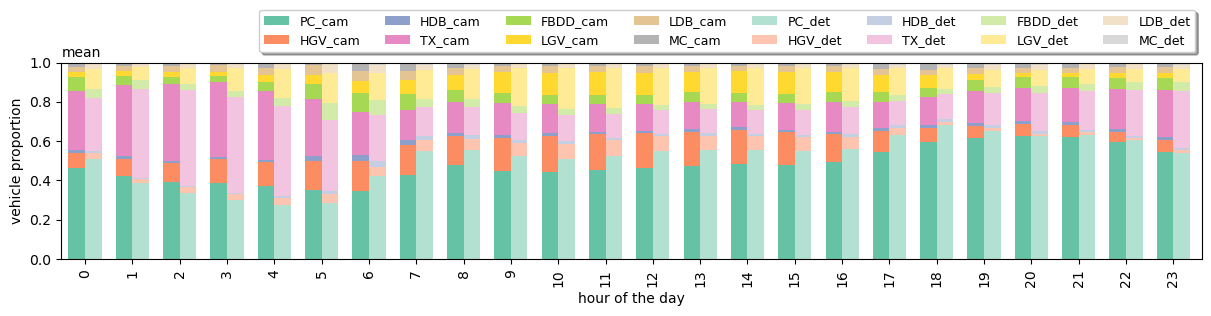

In [73]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(12,3), constrained_layout=True)
types = ['PC', 'HGV', 'HDB', 'TX', 'FBDD', 'LGV', 'LDB', 'MC']

# iterate detector
mean = matched_results_aggregate_hour.groupby(by=['hour']).mean()
detector_results = mean[['%s_det' % type for type in types]]
camera_results = mean[['%s_cam' % type for type in types]]

# plot
width=0.35
camera_results.plot(kind='bar', position=1, width=width, stacked=True, ax=ax, colormap='Set2', alpha=1)
detector_results.plot(kind='bar', position=0, width=width, stacked=True, ax=ax, colormap='Set2', alpha=0.5)

# text
ax.text(-0.5, 1.03, 'mean')

ax.set_xticklabels(list(range(0,24,1)))
ax.set_xlim(-0.5,)
ax.set_ylim(0,1)
ax.set_xlabel('hour of the day')
ax.set_ylabel('vehicle proportion')
ax.legend(loc=1, bbox_to_anchor=(1,1.3), bbox_transform=ax.transAxes, ncol=8, shadow=True, fontsize=9)
plt.show()

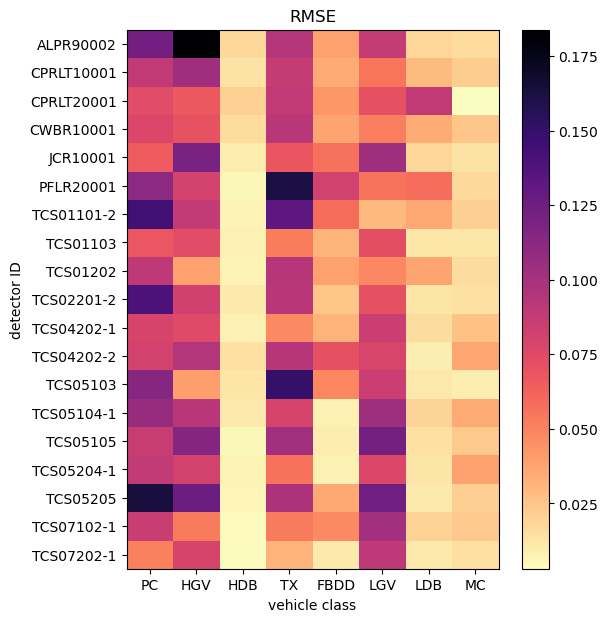

In [63]:
import matplotlib.pyplot as plt
import numpy as np

agg_score_hour = agg_score(matched_results_aggregate_hour)
plt.figure(figsize=(6,7))
plt.imshow(agg_score_hour[agg_score_hour.columns[:-1]], cmap='magma_r', aspect='auto')
plt.colorbar()

types = ['PC', 'HGV', 'HDB', 'TX', 'FBDD', 'LGV', 'LDB', 'MC']
plt.xticks(ticks=list(range(8)), labels=types)
plt.yticks(ticks=list(range(detector_num)), labels=agg_score_hour.index)

plt.title('RMSE')
plt.xlabel('vehicle class')
plt.ylabel('detector ID')
plt.show()

#### Two hours

In [64]:
matched_results_aggregate_2hour = hourly_agg(matched_results, 2)

In [65]:
agg_score(matched_results_aggregate_2hour)

,PC_RMSE,HGV_RMSE,HDB_RMSE,TX_RMSE,FBDD_RMSE,LGV_RMSE,LDB_RMSE,MC_RMSE,Total_RMSE
ALPR90002,0.121584,0.180298,0.015103,0.087177,0.038724,0.087040,0.017863,0.013449,0.561240
CPRLT10001,0.085246,0.099361,0.011069,0.081685,0.034267,0.054622,0.021863,0.020712,0.408825
CPRLT20001,0.069152,0.066462,0.019536,0.078106,0.040614,0.070739,0.087399,0.002634,0.434642
CWBR10001,0.074645,0.066334,0.012625,0.063084,0.032766,0.049546,0.028205,0.021066,0.348270
JCR10001,0.063769,0.114564,0.006812,0.054911,0.056068,0.103583,0.016789,0.011444,0.427940
PFLR20001,0.094722,0.076725,0.004771,0.152727,0.078162,0.055631,0.030703,0.015732,0.509174
TCS01101-2,0.137048,0.084576,0.004701,0.121448,0.052509,0.027811,0.034916,0.019062,0.482071
TCS01103,0.065524,0.071436,0.006599,0.044830,0.031539,0.071882,0.011532,0.012221,0.315563
TCS01202,0.086767,0.037221,0.006232,0.091139,0.037664,0.046031,0.036895,0.015144,0.357091
TCS02201-2,0.137656,0.080889,0.010362,0.083555,0.022745,0.070876,0.011704,0.013241,0.431028


### 2.2 Daily aggregation

In [66]:
matched_results_aggregate_day = matched_results.groupby(by=['detector_id', 'date']).mean()
agg_score(matched_results_aggregate_day)

,PC_RMSE,HGV_RMSE,HDB_RMSE,TX_RMSE,FBDD_RMSE,LGV_RMSE,LDB_RMSE,MC_RMSE,Total_RMSE
ALPR90002,0.113269,0.177850,0.014983,0.065854,0.039238,0.086168,0.020813,0.017310,0.535485
CPRLT10001,0.054581,0.097743,0.009434,0.058820,0.036695,0.055856,0.021824,0.020467,0.355420
CPRLT20001,0.083549,0.051890,0.037687,0.079497,0.039596,0.069883,0.092597,0.001967,0.456666
CWBR10001,0.074905,0.069683,0.012293,0.076460,0.032406,0.043218,0.036346,0.020353,0.365663
JCR10001,0.050779,0.100383,0.009169,0.046637,0.052641,0.093687,0.014857,0.011909,0.380061
PFLR20001,0.057433,0.077158,0.004780,0.149762,0.073088,0.049556,0.019324,0.011475,0.442575
TCS01101-2,0.094471,0.080743,0.005376,0.099057,0.040080,0.019551,0.033164,0.018223,0.390664
TCS01103,0.038170,0.064350,0.007958,0.019384,0.030475,0.069752,0.010593,0.013095,0.253778
TCS01202,0.040760,0.033718,0.006643,0.040302,0.034597,0.037158,0.033636,0.014800,0.241615
TCS02201-2,0.117842,0.071890,0.009033,0.066377,0.022625,0.066145,0.007290,0.012195,0.373397


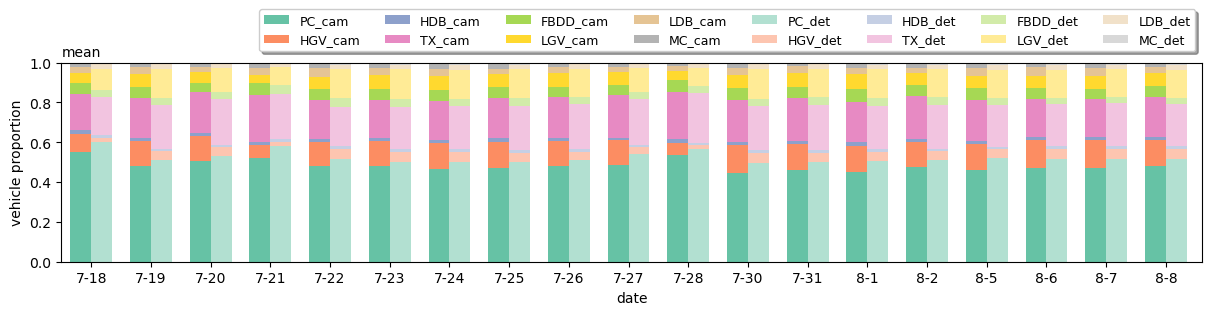

In [67]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(12,3), constrained_layout=True)
types = ['PC', 'HGV', 'HDB', 'TX', 'FBDD', 'LGV', 'LDB', 'MC']

# iterate detector
mean = matched_results_aggregate_day.reset_index().groupby(by=['date']).mean(numeric_only=True)
detector_results = mean[['%s_det' % type for type in types]]
camera_results = mean[['%s_cam' % type for type in types]]

# plot
width=0.35
camera_results.plot(kind='bar', position=1, width=width, stacked=True, ax=ax, colormap='Set2', alpha=1)
detector_results.plot(kind='bar', position=0, width=width, stacked=True, ax=ax, colormap='Set2', alpha=0.5)

# text
ax.text(-0.5, 1.03, 'mean')

ax.set_xticklabels(['%d-%d' % (date.month, date.day) for date in mean.index], rotation=0)
ax.set_xlim(-0.5,)
ax.set_ylim(0,1)
ax.set_xlabel('date')
ax.set_ylabel('vehicle proportion')
ax.legend(loc=1, bbox_to_anchor=(1,1.3), bbox_transform=ax.transAxes, ncol=8, shadow=True, fontsize=9)
plt.show()

### 2.3 Residual

#### One hour

In [68]:
for type in types:
    matched_results_aggregate_hour['%s_rsd'%type] = matched_results_aggregate_hour['%s_cam'%type] - matched_results_aggregate_hour['%s_det'%type]

In [69]:
matched_results_aggregate_hour

date  hour    PC_det   HGV_det   
detector_id hour_group                                                 
ALPR90002   0          2024-07-28 09:20:00   0.0  0.530139  0.057333  \
            1          2024-07-28 09:20:00   1.0  0.444556  0.007333   
            2          2024-07-28 09:20:00   2.0  0.384444  0.005722   
            3          2024-07-28 09:20:00   3.0  0.360556  0.008389   
            4          2024-07-28 09:20:00   4.0  0.335444  0.006889   
...                                    ...   ...       ...       ...   
TCS07202-1  19         2024-07-25 06:24:00  19.0  0.622667  0.015467   
            20         2024-07-25 06:24:00  20.0  0.592600  0.017200   
            21         2024-07-25 06:24:00  21.0  0.621667  0.015000   
            22         2024-07-25 06:24:00  22.0  0.592533  0.011867   
            23         2024-07-25 06:24:00  23.0  0.539067  0.014800   

                         HDB_det    TX_det  FBDD_det   LGV_det   LDB_det   
detector_id hour_group                                                     
ALPR90002   0           0.010806  0.248917  0.008556  0.125833  0.016250  \
            1           0.005667  0.472611  0.000167  0.060389  0.008056   
            2           0.002611  0.547444  0.000444  0.056889  0.001944   
            3           0.000000  0.542889  0.000389  0.082111  0.004833   
            4           0.000722  0.527278  0.000000  0.125222  0.004667   
...                          ...       ...       ...       ...       ...   
TCS07202-1  19          0.013000  0.170200  0.049000  0.108333  0.011200   
            20          0.014133  0.196133  0.056867  0.099533  0.012400   
            21          0.012667  0.191667  0.052933  0.084733  0.010933   
            22          0.013667  0.215067  0.067733  0.079667  0.010667   
            23          0.014333  0.250600  0.088267  0.075333  0.007333   

                          MC_det  ...   LDB_cam    MC_cam    PC_rsd   HGV_rsd   
detector_id hour_group            ...                                           
ALPR90002   0           0.002111  ...  0.035337  0.006481 -0.028280  0.041709  \
            1           0.000889  ...  0.026933  0.040154 -0.079574  0.175307   
            2           0.000000  ...  0.020940  0.023810  0.032980  0.115234   
            3           0.000778  ...  0.012346  0.015873  0.029113  0.249662   
            4           0.000000  ...  0.012987  0.024074  0.073931  0.142342   
...                          ...  ...       ...       ...       ...       ...   
TCS07202-1  19          0.010400  ...  0.015124  0.028583 -0.020053  0.032945   
            20          0.011067  ...  0.007690  0.022772  0.022424  0.022904   
            21          0.010533  ...  0.012795  0.018207  0.016059  0.052796   
            22          0.009267  ...  0.011503  0.015990  0.018177  0.034705   
            23          0.010400  ...  0.005557  0.026464  0.025481  0.052722   

                         HDB_rsd    TX_rsd  FBDD_rsd   LGV_rsd   LDB_rsd   
detector_id hour_group                                                     
ALPR90002   0           0.023016 -0.000257  0.041963 -0.101553  0.019087  \
            1           0.036699 -0.159319  0.019610 -0.050533  0.018878   
            2           0.020815 -0.172073  0.013658 -0.052921  0.018996   
            3           0.000000 -0.236287  0.007548 -0.072587  0.007512   
            4           0.011623 -0.211289  0.037879 -0.087103  0.008320   
...                          ...       ...       ...       ...       ...   
TCS07202-1  19          0.006554  0.030172  0.002296 -0.074287  0.003924   
            20          0.004308  0.006056  0.003762 -0.066383 -0.004710   
            21          0.002622 -0.014467 -0.000581 -0.066097  0.001861   
            22          0.001999  0.003979 -0.005223 -0.061662  0.000837   
            23         -0.001465 -0.022570 -0.008194 -0.060395 -0.001777   

                          MC_rsd  
detector_id hour_group            

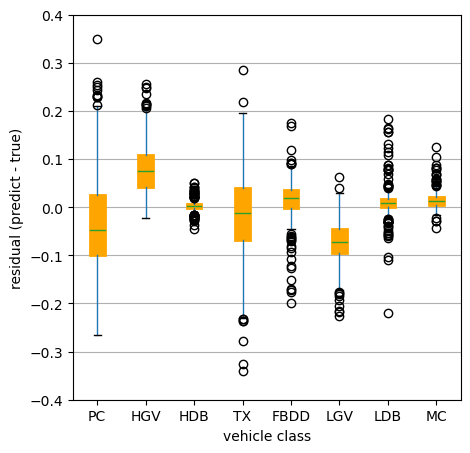

In [70]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(5,5))

# boxplot
colors = plt.get_cmap('Set2')(range(8))
boxplot = matched_results_aggregate_hour[['%s_rsd'%type for type in types]].boxplot(
    ax=ax, patch_artist=True,
    widths=0.3,
    boxprops=dict(facecolor='orange', color='orange', linewidth=2),
)

ax.set_xlabel('vehicle class')
ax.set_ylabel('residual (predict - true)')
ax.set_ylim(-0.4,0.4)
ax.set_xticklabels(types)
ax.grid(axis='x')
plt.show()

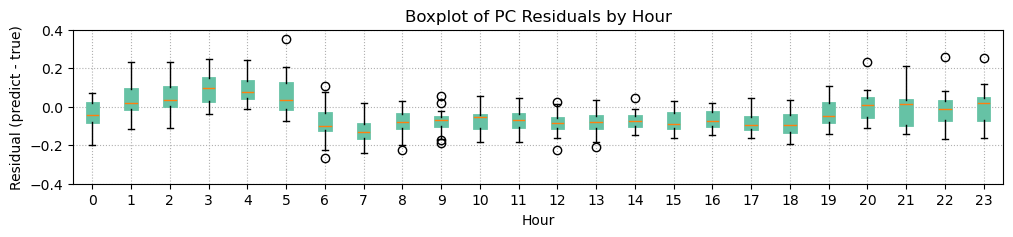

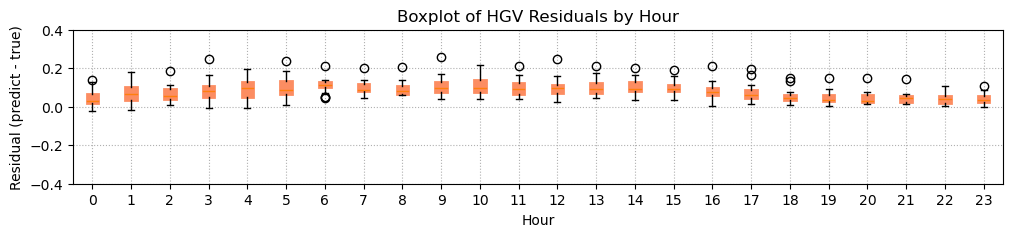

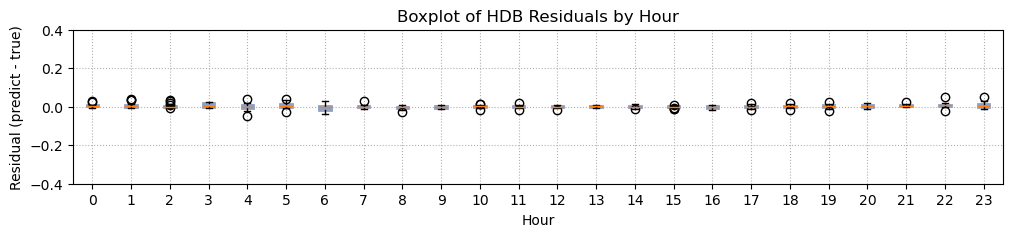

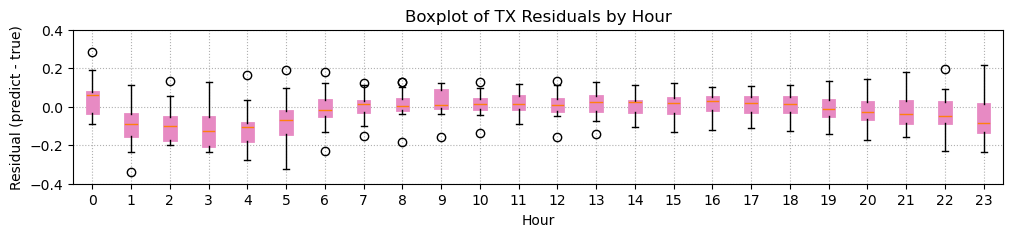

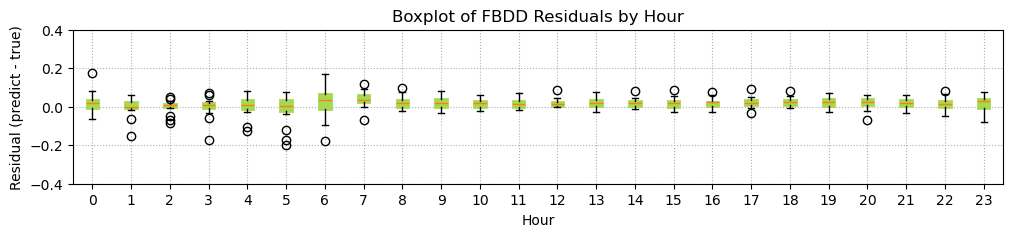

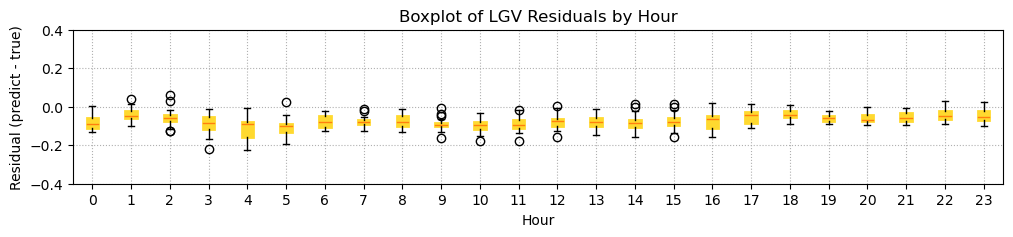

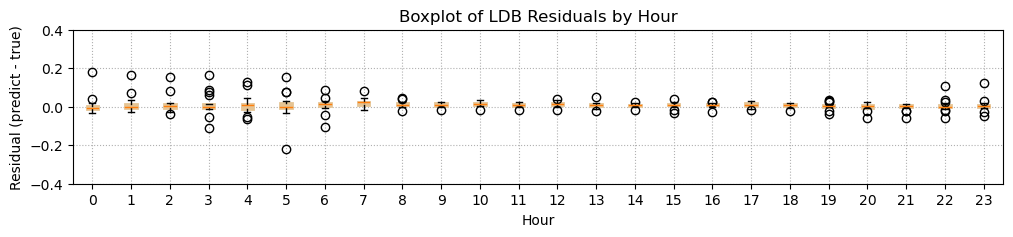

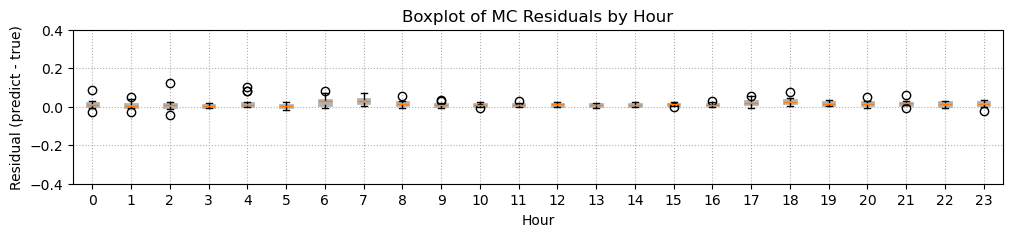

In [71]:
import matplotlib.pyplot as plt

# 设置颜色
colors = plt.get_cmap('Set2')(range(len(types)))

# 为每个 type 生成单独的图
for i, type in enumerate(types):
    fig, ax = plt.subplots(figsize=(12,2))
    data = matched_results_aggregate_hour[['hour', '%s_rsd' % type]]
    ax.boxplot([data[data['hour'] == hour]['%s_rsd' % type] for hour in data['hour'].unique()],
               patch_artist=True,
               widths=0.3,
               boxprops=dict(facecolor=colors[i], color=colors[i], linewidth=2))
    ax.set_title(f'Boxplot of {type} Residuals by Hour')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Residual (predict - true)')
    ax.set_ylim(-0.4, 0.4)
    ax.set_xticks(range(1, len(data['hour'].unique()) + 1))
    ax.set_xticklabels([str(h) for h in range(24)])
    ax.grid(linestyle=":")
    plt.show()


---

In [72]:
# for i in range(21):
#     plot_agg(matched_results_aggregate_hour, 1, i)